# Siconos software demo and tutorial

## Tutorial 2 : a ball bouncing on the ground

### Import siconos components
you may need to set PYTHONPATH or sys.path if siconos python packages are not in standard places.

In [15]:
import sys
# Update the following line depending on your siconos python installation.
sys.path.append("/usr/local/lib/python2.7/site-packages/")
sys.path.append("/Users/Franck/Library/Python/2.7/lib/python2.7/site-packages/")

In [16]:
# Main interface to siconos functionnalities : 
# non smooth model description, simulation setup ...
import siconos.kernel as sk    

# "Low-level" nonsmooth solvers
import siconos.numerics as sn

# Python package for scientific computing
import numpy as np

# Part 1 - NSDS definition 
--> Dynamical systems, constraints, nonsmooth laws ...

## The dynamical system

Consider the following example, a ball bouncing on the ground.
As described in the figure below, we consider a ball of mass m and radius R, described by 3 generalized coordinates q=(z,x,θ).The ball is subjected to the gravity g. The system is also constituted by a rigid plane, defined by its position with respect to the axis Oz. We assume that the position of the plane is fixed.

![BouncingBall](figures/BouncingBall.png "BouncingBall")

The equation of motion of the ball is given by

$$
   \dot q = v \\
   M\dot v = F_{ext}(t) + p\\
   with \ \ M=\left[\begin{array}{ccc}
   m &0 &0 \\
   0 & m & 0 \\
   0 & 0 & I
   \end{array}\right] \ \ , \ \ I = \frac{2}{5}mR^2 \ \ and \ \ F_{ext} = \left[\begin{array}{c}
   -m g \\
   0  \\
   0
   \end{array}\right]
$$
with

* M the inertia term, a $n\times{}n$ matrix.
* p the force due to the non-smooth law, ie the reaction at impact. 
* $F_{ext}(t)  \mathcal R \mapsto \mathcal R^{n}$ the given external force.

we get a second-order Lagrangian linear system defined in Siconos with **LagrangianLinearTIDS**:

In [17]:
# -- Set dynamical system parameters --
x = [1, 0, 0]    # initial position
v = [0, 0, 0]    # initial velocity
radius = 0.1
m = 1.
g = 9.81
mass = np.eye(3)  # mass matrix
mass[2, 2] = 2. / 5 * radius * radius
# -- Build the dynamical system --
ball = sk.LagrangianLinearTIDS(x, v, mass)
# -- Set external forces --
weight = [-m * g, 0, 0]
ball.setFExtPtr(weight)

*Remark: when specific functions are needed for external forces, a new class, deriving from LagrangianLinearTIDS can be created*
*Consider the following example:*

In [18]:
# definition of a new class of dynamical systems, which inherits from linear lagrangian:
class MyDynamicalSystem(sk.LagrangianLinearTIDS):
    
    def computeFext(self, time):
        print 'compute external forces ...'
        self.setFExtPtr([np.sin(time), np.cos(time), time **2])
        return [np.sin(time), np.cos(time), time **2]

# and create a new instance:
another_ball = MyDynamicalSystem(x, v, mass)
another_ball.computeFext(0.1)


compute external forces ...


[0.099833416646828155, 0.99500416527802571, 0.010000000000000002]

To get more details on this (or any other) class of DS, try:

help(classname)

In [19]:
#help(MyDynamicalSystem)


## Nonsmooth laws and constraints : the interaction(s) between dynamical systems

Now, the nonsmooth part of the system must be defined, namely what are the nonsmooth laws and constraints between the variables. In Siconos, the definition of a nonsmooth law and a relation between one or two dynamical systems is called an Interaction (see Interactions between dynamical systems). Thus, the definition of a set of dynamical systems and of interactions between them will lead to the complete nonsmooth dynamical system.

Clearly, the constraint here must state that the ball must stay above the ground, and when it hits the ground, a reaction force appears. Thus, as a local variables of the Interaction, we introduce $y$ as the distance between the ball and the floor and $\lambda$ as the multiplier that corresponds to the reaction at contact.
The constraint writes:

$$y(t) = q(t) - R - ground\_position$$

in Siconos, this corresponds to a **LagrangianLinearTIR** (TIR stands for time-invariant relation), written as

$$
\begin{array}{ccc}
y &=& Hq + b\\
p &=& H^t \lambda
\end{array}, \ \ \ \ H = [1 \ 0 \ 0], b = [ground\_position]
$$

In [20]:
# ball-floor
H = np.zeros((1, 3))
H[0, 0] = 1.
# b = ground position
ground_position = [0.5]
relation = sk.LagrangianLinearTIR(H)

The behavior at impact must be defined. We introduce a restitutive coefficient $e$ such that

$$\textrm{if} \ y=0, \ \dot y(t^+) = -e \dot y(t^-)$$
$t^+$ and $t^-$ being post and pre-impact times.
 
At impact, the unilateral constraint is such that

$$0 \leq y \perp \lambda \geq 0$$
which simply states that when the ball is not in contact, the reaction is null and the distance to the ground is positive while when the ball touch the ground, the reaction must be positive.

This relation and the pre-post velocity relation are defined with a **NewtonImpactNSL**


In [21]:
e = 0.9
nonsmooth_law = sk.NewtonImpactNSL(e)

A nonsmooth law and a relation define something called **Interaction** in Siconos

In [22]:
interaction = sk.Interaction(nonsmooth_law, relation)

Notice that this interaction just describe some relations and laws but is not connected to any real dynamical system, for the moment.
  
The modeling part is almost complete, since only one dynamical system and one interaction are needed to describe the problem.
They must be gathered into a specific object, the **Model**.
A model contains a nonsmooth dynamical system and the description of its simulation. The building of this object is quite simple: just set the time window for the simulation, include dynamical systems and link them to the correct interactions.

                      NSDS == a set of Dynamical Systems + a set of Interactions


In [23]:
# dynamical systems and interactions must be gathered into a model, defined on a time interval
t0 = 0. # initial time
T = 10. # duration of the simulation
BouncingBall = sk.Model(t0, T)
# 1 - add the dynamical system in the nonsmooth dynamical system of the model
BouncingBall.nonSmoothDynamicalSystem().insertDynamicalSystem(ball)
# 2 - link the interaction and the dynamical system
BouncingBall.nonSmoothDynamicalSystem().link(interaction, ball)

# Part 2 - Simulation process definition

It's time to describe how our nonsmooth dynamical system will be discretize, formulate and solve.
You need now to define how the nonsmooth dynamical system will be integrated over time. This is the role of the **Simulation**, which must set:

* how dynamical systems are discretized and integrate over a time step
* how the resulting nonsmooth problem(s) will be formalized and solved

Two different strategies are available : event-capturing (a.k.a time stepping) schemes and event-driven schemes. 

For this example, an event-capturing strategy will be used, with a Moreau-Jean integrator and a LCP (Linear Complementarity Problem) formulation.

Let us start with the 'one-step integrator', i.e. the description of the discretisation and integration of the dynamics over a time step, between time $t_i$ and $t_{i+1}$. The integration of the dynamics over the time step is based on a $\theta$-method, and the time-discretisation leads to:

$$
\begin{array}{ccc}
    \dot y_{k+1} &=& Hv^{free}_{k}  +  HM^{-1}H^t\lambda_{k+1} \\
    v^{free}_k &=&  v_k + M^{-1}hF_{ext,k+\theta}\\
    if \bar y_{k,\gamma} \leq 0 \ &then& \ 0 \leq \dot y_{k+1} \perp \lambda_{k+1} \geq 0 
  \end{array}
$$

which turns to be a Linear Complementarity System.

The time-discretisation and the LCP are implemented as:

In [24]:
theta = 0.5
osi = sk.MoreauJeanOSI(theta)
osnspb = sk.LCP()
# You can change the LCP solver like this:
#osnspb = sk.LCP(sn.SICONOS_LCP_ENUM)
#osnspb = sk.LCP(sn.SICONOS_LCP_PGS)
#sn.SICONOS_LCP

Depending on the chosen formulation, different solvers are available. You can for example change the default (Lemke)
for a non-symmetric QP, as below.
A complete list of available solvers can be found in documentation (LCP solvers: http://siconos.gforge.inria.fr/users_guide/lcp_solvers.html#lcp-solvers).

Then the last step consists in the simulation creation, with its time discretisation

In [25]:
# simulation and time discretisation
time_step =  0.005
td = sk.TimeDiscretisation(t0, time_step)
simu = sk.TimeStepping(td, osi, osnspb)

The connection with the nonsmooth dynamical system is done through the **Model**

In [26]:
BouncingBall.setSimulation(simu)
BouncingBall.initialize()

The model is now complete and ready to run

## Leading the simulation process

For the present case, x,y and λ at each time step are needed for postprocessing. Here is an example on how to get and save them in a numpy array

In [27]:
N = int((T - t0) / simu.timeStep()) + 1
# numpy array used to save data at each time step, for post-processing
data_plot = np.zeros((N, 7))

lamb = interaction.lambda_(1)
q = ball.q()
v = ball.velocity()
p = ball.p(1)
k = 0
# initial state
data_plot[k, 0] = t0
data_plot[k, 1] = q[0]
data_plot[k, 2] = v[0]
data_plot[k, 3] = p[0]
data_plot[k, 4] = lamb[0]

def compute_energy(v, z):
    return 0.5 * np.dot(v, np.dot(mass, v)), m * g * z

data_plot[k, 5:] = compute_energy(v, q[0])

k += 1

while simu.hasNextEvent():
    simu.computeOneStep() # Build and solve the LCP
    data_plot[k, 0] = simu.nextTime()
    data_plot[k, 1] = q[0]
    data_plot[k, 2] = v[0]
    data_plot[k, 3] = p[0]
    data_plot[k, 4] = lamb[0]
    data_plot[k, 5:] = compute_energy(v, q[0])
    k += 1 
    simu.nextStep() # Save current state and prepare next step


* *hasNextEvent()* is true as long as there are events to be considered, i.e. until T is reached
* *nextStep()* is mainly used to increment the time step, save current state and prepare initial values for next step.
* *computeOneStep()* performs computation over the current time step. In the Moreau's time stepping case, it will first integrate the dynamics to
  obtain the so-called free-state, that is without non-smooth effects, then it will formalize and solve a LCP before re-integrate the dynamics using the LCP results. 

The results can now be postprocessed, using matplotlib pyplot for example

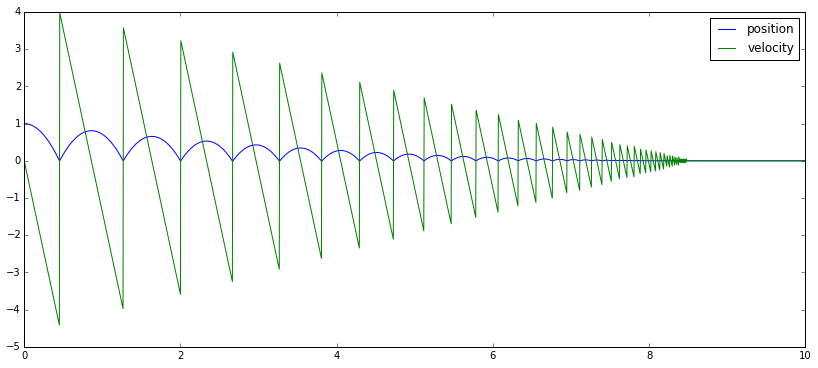

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline  
fig_size = [14, 6]
plt.rcParams["figure.figsize"] = fig_size
time = data_plot[:, 0]
#plt.subplot(411)
#plt.title('position')
plt.plot(time, data_plot[:, 1], label='position')
plt.plot(time, data_plot[:, 2], label='velocity')
plt.grid()
plt.legend()
plt.grid()


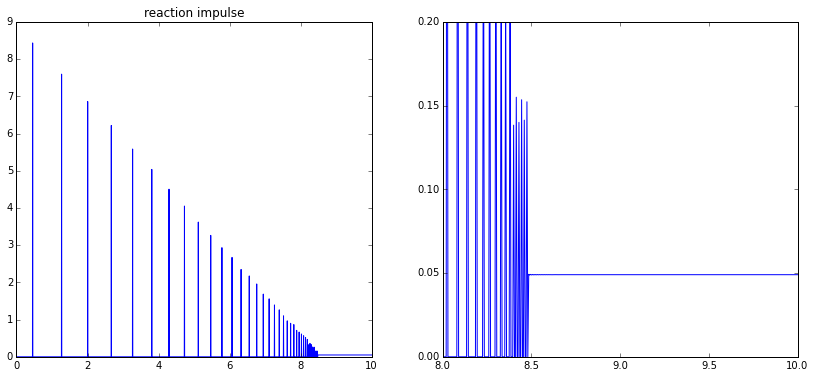

In [29]:
plt.subplot(121)
plt.plot(time, data_plot[:, 4])
plt.title('reaction impulse')
plt.subplot(122)
plt.xlim(8,10)
plt.ylim(0,0.2)
plt.plot(time, data_plot[:, 4])

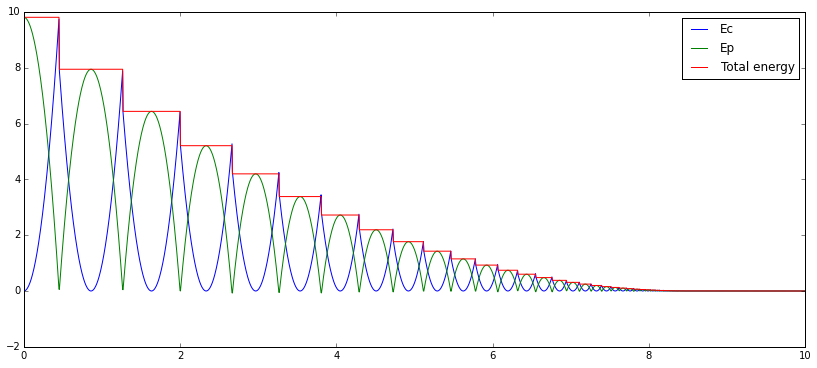

In [30]:
Ec = data_plot[:, 5]
Ep = data_plot[:, 6]
plt.plot(time, Ec, label='Ec')
plt.plot(time, Ep, label='Ep')
plt.plot(time, Ec + Ep, label='Total energy')
plt.legend()